In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm
import sklearn
from datetime import datetime
from sklearn.linear_model import LinearRegression
from linearmodels.panel import BetweenOLS, PanelOLS
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

%matplotlib inline

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Предобработка данных

## Загрузка

In [2]:
# продажи в ВСП
sales = pd.read_csv('data/vsp_sales_1718.txt', sep='\t', decimal=',')
sales.rename(columns = {'last_day(DATE_REPORT_SRC)': 'report_dt'}, inplace = True)

sales.head()

,report_dt,urf_code_uni,product_group,sales_up,sales_cnt
0,28.02.2018,067_8369_05,ПК,33.25,25
1,28.02.2018,067_1791_052,ЖК,18.36,17
2,31.07.2017,054_6991_0344,ВыдачаПК,5.59,13
3,31.10.2017,067_8634_058,ВыдачаБК,88.40,520
4,31.10.2017,016_8598_0161,ПрочиеУП,0.13,1


In [3]:
# талоны в ВСП
tickets = pd.read_csv('data/vsp_split_1718.txt', sep='\t', decimal=',')
tickets.rename(columns = {'last_day(calendar_date)': 'report_dt'}, inplace = True)

tickets.head()

,report_dt,urf_code_uni,ticket_cnt_all,ticket_cnt_pl,ticket_cnt_card_old,ticket_cnt_card_new,ticket_cnt_da,ticket_cnt_mg
0,31.05.2018,054_8623_0419,589,72,289,49,169,10
1,31.08.2017,054_8624_0425,2050,211,848,307,639,45
2,28.02.2018,040_9040_00108,986,93,459,246,178,10
3,31.08.2017,042_9042_0433,1412,180,381,233,587,31
4,30.06.2017,052_8619_098,2953,573,1332,611,402,35


In [4]:
# отработанные часы в ВСП
work_hours = pd.read_csv('data/vsp_work_hour_1718.txt', sep='\t', decimal=',')
work_hours.rename(columns = {'last_day(calendar_date)': 'report_dt'}, inplace = True)

work_hours.head()

,report_dt,urf_code_uni,time_hours
0,31.05.2018,054_8623_0419,211.47
1,31.08.2017,054_8624_0425,512.00
2,28.02.2018,040_9040_00108,245.30
3,31.08.2017,042_9042_0433,592.00
4,30.06.2017,052_8619_098,767.50


In [5]:
vsp_data = pd.merge(sales, tickets, on=['urf_code_uni', 'report_dt'])
vsp_data = pd.merge(vsp_data, work_hours, on=['urf_code_uni', 'report_dt'])
vsp_data ['report_dt'] = pd.DatetimeIndex(vsp_data.report_dt)
vsp_data ['month'] = vsp_data.report_dt.dt.month
print('Всего ВСП до чистки: %d' % len(vsp_data.urf_code_uni.unique()))
vsp_data.head()

Всего ВСП до чистки: 5961


,report_dt,urf_code_uni,product_group,sales_up,sales_cnt,ticket_cnt_all,ticket_cnt_pl,ticket_cnt_card_old,ticket_cnt_card_new,ticket_cnt_da,ticket_cnt_mg,time_hours,month
0,2018-02-28,067_8369_05,ПК,33.25,25,1075,120,629,224,64,38,363.9,2
1,2018-02-28,067_8369_05,ПрочиеУП,0.39,3,1075,120,629,224,64,38,363.9,2
2,2018-02-28,067_8369_05,ВыдачаБК,82.45,485,1075,120,629,224,64,38,363.9,2
3,2018-02-28,067_8369_05,НПО,0.75,5,1075,120,629,224,64,38,363.9,2
4,2018-02-28,067_8369_05,ОСЗ,1.08,4,1075,120,629,224,64,38,363.9,2


## Чистка данных

In [6]:
bad_vsp_df = pd.read_csv('data/VSP_bad_schedule.txt', sep='\t', decimal=',')
bad_vsp = list(bad_vsp_df['VSP'].values)

vsp_data = vsp_data[~vsp_data.urf_code_uni.isin(bad_vsp)]
print('ВСП с полным графиком: %d' % len(vsp_data.urf_code_uni.unique()))

ВСП с полным графиком: 5786


In [7]:
vsp_intensity = vsp_data.groupby(['urf_code_uni','report_dt'])['ticket_cnt_all','time_hours'].max().reset_index()
vsp_intensity['intensity'] = vsp_intensity.ticket_cnt_all/vsp_intensity.time_hours*160
vsp_intensity['intensity_log'] = np.log(vsp_intensity['intensity'])
vsp_intensity.head()

,urf_code_uni,report_dt,ticket_cnt_all,time_hours,intensity,intensity_log
0,013_8592_01,2017-05-31,1604,421.0,609.596200,6.412797
1,013_8592_01,2017-06-30,1433,424.2,540.499764,6.292494
2,013_8592_01,2017-07-31,1502,414.7,579.503255,6.362171
3,013_8592_01,2017-08-31,1678,544.0,493.529412,6.201582
4,013_8592_01,2017-09-30,1356,441.0,491.972789,6.198423


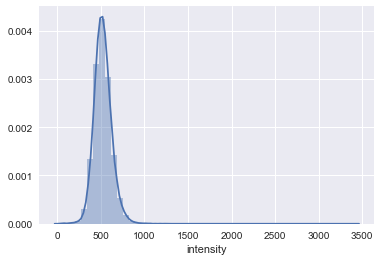

In [8]:
sns.distplot(vsp_intensity['intensity']);

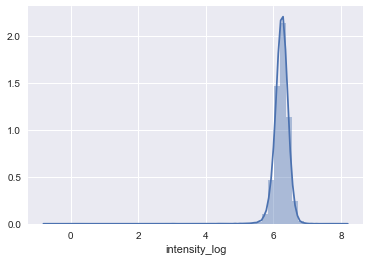

In [9]:
sns.distplot(vsp_intensity['intensity_log'])
plt.show()

ВСП без выбросов по общей интенсивности: 5492


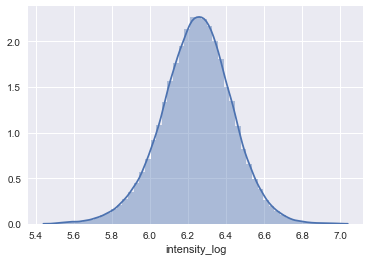

In [10]:
#bad_vsp += list(vsp_intensity[~vsp_intensity.intensity.between(150,950)].urf_code_uni.values)
bad_vsp += list(vsp_intensity[~vsp_intensity.intensity_log.between(5.5,7)].urf_code_uni.values)
vsp_data = vsp_data[~vsp_data.urf_code_uni.isin(bad_vsp)]
print('ВСП без выбросов по общей интенсивности: %d' % len(vsp_data.urf_code_uni.unique()))
#sns.distplot(vsp_intensity.loc[~vsp_intensity.urf_code_uni.isin(bad_vsp),'intensity']);
sns.distplot(vsp_intensity.loc[~vsp_intensity.urf_code_uni.isin(bad_vsp),'intensity_log']);

In [11]:
agg = {'ticket_cnt_all':'max', 'sales_up':'sum'}
vsp_conv = vsp_data.groupby(['urf_code_uni','report_dt'])['ticket_cnt_all','sales_up'].agg(agg).reset_index()
vsp_conv['conv'] = vsp_conv.sales_up/vsp_conv.ticket_cnt_all*1000
vsp_conv['conv_log'] = np.log(vsp_conv['conv'])
vsp_conv['ticket_cnt_all_log'] = np.log(vsp_conv['ticket_cnt_all'])
vsp_conv.head()

,urf_code_uni,report_dt,ticket_cnt_all,sales_up,conv,conv_log,ticket_cnt_all_log
0,013_8592_01,2017-05-31,1604,333.80,208.104738,5.338042,7.380256
1,013_8592_01,2017-06-30,1433,299.34,208.890440,5.341810,7.267525
2,013_8592_01,2017-07-31,1502,298.33,198.621838,5.291403,7.314553
3,013_8592_01,2017-08-31,1678,399.46,238.057211,5.472511,7.425358
4,013_8592_01,2017-09-30,1356,306.81,226.261062,5.421689,7.212294


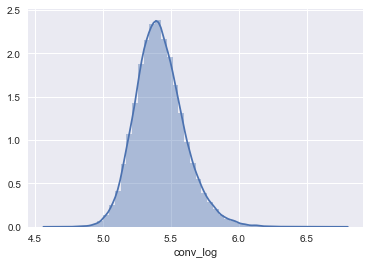

In [12]:
sns.distplot(vsp_conv['conv_log']);

ВСП без выбросов по общей конвертации: 5467


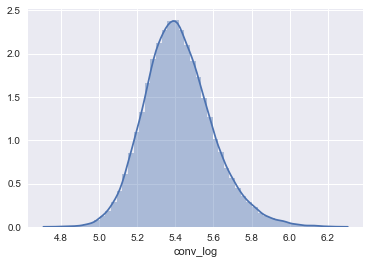

In [13]:
bad_vsp += list(vsp_conv[~vsp_conv.conv_log.between(4.75,6.25)].urf_code_uni.values)
vsp_data = vsp_data[~vsp_data.urf_code_uni.isin(bad_vsp)]
print('ВСП без выбросов по общей конвертации: %d' % len(vsp_data.urf_code_uni.unique()))
sns.distplot(vsp_conv.loc[~vsp_conv.urf_code_uni.isin(bad_vsp),'conv_log']);

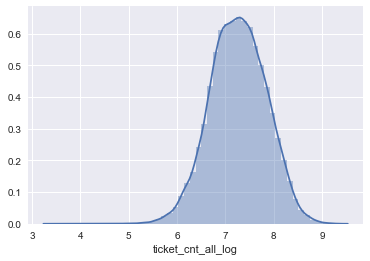

In [14]:
sns.distplot(vsp_conv['ticket_cnt_all_log']);

ВСП без выбросов по общему клиентопотоку: 5428


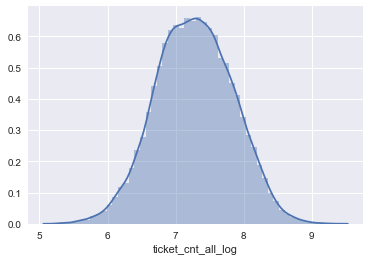

In [15]:
bad_vsp += list(vsp_conv[~vsp_conv.ticket_cnt_all_log.between(5.25,10)].urf_code_uni.values)
vsp_data = vsp_data[~vsp_data.urf_code_uni.isin(bad_vsp)]
print('ВСП без выбросов по общему клиентопотоку: %d' % len(vsp_data.urf_code_uni.unique()))
sns.distplot(vsp_conv.loc[~vsp_conv.urf_code_uni.isin(bad_vsp),'ticket_cnt_all_log']);

# Панельная регрессия

In [16]:
def data_for_regression (vsp_data_new, product = True):
       
    if product:
        agg_func = {'sales_up':'sum', 'intensity':'mean', 'ticket_cnt_all':'mean', 'time_hours': 'mean', 
                target: 'mean','month':'mean'}
        vsp_data_reg = vsp_data_new.groupby(['urf_code_uni','report_dt']).agg(agg_func).reset_index()
        vsp_data_reg['conv'] = vsp_data_reg[target]
        vsp_data_reg['conv_log'] = np.log(vsp_data_reg[target])
    else: 
        agg_func = {'sales_up':'sum', 'intensity':'mean', 'ticket_cnt_all':'mean', 'time_hours': 'mean',
                      'month':'mean'}
        vsp_data_reg = vsp_data_new.groupby(['urf_code_uni','report_dt']).agg(agg_func).reset_index()
        vsp_data_reg['conv'] = vsp_data_reg.sales_up / vsp_data_reg.ticket_cnt_all * 1000
        vsp_data_reg['conv_log'] = np.log(vsp_data_reg['conv'])
    vsp_data_reg = vsp_data_reg.sort_values(by = ['urf_code_uni', 'report_dt'])
    vsp_data_reg = vsp_data_reg.set_index(['urf_code_uni', 'report_dt'])
    vsp_data_reg['conv_L'] = vsp_data_reg.groupby(level=0)['conv'].shift(1)
    vsp_data_reg['conv_log_L'] = vsp_data_reg.groupby(level=0)['conv_log'].shift(1)
    vsp_data_reg['intensity_log'] = np.log(vsp_data_reg.intensity)
    vsp_data_reg['ticket_cnt_all_log'] = np.log(vsp_data_reg.ticket_cnt_all)
    
    vsp_data_reg = vsp_data_reg.replace([np.inf, -np.inf], np.nan)
    vsp_data_reg = vsp_data_reg.dropna()
    vsp_data_reg['period'] = pd.Categorical(vsp_data_reg.reset_index().report_dt)
    return vsp_data_reg

conv_cols = [
    ['pk_conv', 'ПК', 'ticket_cnt_pl'],
    ['da_conv', 'Вклады', 'ticket_cnt_da'],
    ['dk_conv', 'ДК', 'ticket_cnt_card_new'],
    ['bk_conv', 'ВыдачаБК', 'ticket_cnt_card_old'],
    ['mg_conv', 'ЖК', 'ticket_cnt_mg'],
    ['zb_conv', 'ЗащБлиз', 'ticket_cnt_all'],
    ['zd_conv', 'ЗащДом', 'ticket_cnt_all'],
    ['zk_conv', 'ССП', 'ticket_cnt_pl'] ,
    
]
pd_cols = pd.DataFrame(conv_cols)

def convertion_calc(data):
    for col in conv_cols:
        data[col[0]] = 0
        ind = (data['product_group'] == col[1])
        data.loc[ind, col[0]] = data.loc[ind, 'sales_up'] / data.loc[ind, col[2]] * 1000
    return data

In [17]:
vsp_data_new = vsp_data.copy()
vsp_data_new['intensity'] = vsp_data_new.ticket_cnt_all/vsp_data_new.time_hours*160
vsp_data_reg = data_for_regression(vsp_data_new, product=False)

vsp_data_reg.head()

sales_up   intensity  ticket_cnt_all  time_hours  \
urf_code_uni report_dt                                                      
013_8592_01  2017-06-30    299.34  540.499764            1433       424.2   
             2017-07-31    298.33  579.503255            1502       414.7   
             2017-08-31    399.46  493.529412            1678       544.0   
             2017-09-30    306.81  491.972789            1356       441.0   
             2017-10-31    341.85  469.578544            1532       522.0   

                         month        conv  conv_log      conv_L  conv_log_L  \
urf_code_uni report_dt                                                         
013_8592_01  2017-06-30      6  208.890440  5.341810  208.104738    5.338042   
             2017-07-31      7  198.621838  5.291403  208.890440    5.341810   
             2017-08-31      8  238.057211  5.472511  198.621838    5.291403   
             2017-09-30      9  226.261062  5.421689  238.057211    5.472511   
             2017-10-31     10  223.139687  5.407798  226.261062    5.421689   

                         intensity_log  ticket_cnt_all_log     period  
urf_code_uni report_dt                                                 
013_8592_01  2017-06-30       6.292494            7.267525 2017-06-30  
             2017-07-31       6.362171            7.314553 2017-07-31  
             2017-08-31       6.201582            7.425358 2017-08-31  
             2017-09-30       6.198423            7.212294 2017-09-30  
             2017-10-31       6.151836            7.334329 2017-10-31

In [18]:
np.corrcoef(vsp_data_reg.intensity_log, vsp_data_reg.ticket_cnt_all_log)

array([[1.       , 0.2821551],
       [0.2821551, 1.       ]])

In [19]:
"Time effects dummies"
vsp_data_reg['month'] = pd.Categorical(vsp_data_reg.month)
exog_vars = ['intensity_log', 'ticket_cnt_all_log', 'period']
exog = sm.add_constant(vsp_data_reg[exog_vars])

mod = PanelOLS(vsp_data_reg.conv_log, exog, entity_effects = True)
fe_res_time = mod.fit()

print(fe_res_time.rsquared_inclusive)
print(fe_res_time.params)
print(fe_res_time)

0.8013286677808652
const                         9.346439
intensity_log                -0.350928
ticket_cnt_all_log           -0.246885
period.2017-07-31 00:00:00    0.043641
period.2017-08-31 00:00:00    0.070536
period.2017-09-30 00:00:00   -0.010647
period.2017-10-31 00:00:00    0.016098
period.2017-11-30 00:00:00    0.061203
period.2017-12-31 00:00:00    0.109854
period.2018-01-31 00:00:00   -0.047515
period.2018-02-28 00:00:00    0.018781
period.2018-03-31 00:00:00    0.063748
period.2018-04-30 00:00:00    0.123332
period.2018-05-31 00:00:00    0.196386
period.2018-06-30 00:00:00    0.128604
Name: parameter, dtype: float64
                          PanelOLS Estimation Summary                           
Dep. Variable:               conv_log   R-squared:                        0.5398
Estimator:                   PanelOLS   R-squared (Between):             -0.1399
No. Observations:               64465   R-squared (Within):               0.5398
Date:                Fri, Nov 02 2018   

In [26]:
1+fe_res_time.params[2]

0.7531152207949936

# Расчет доверительных интервалов

In [36]:
?fe_res_time.predict

In [71]:
y_pred = fe_res_time.estimated_effects['estimated_effects'].values + fe_res_time.fitted_values['fitted_values'].values

y_combined = vsp_data_reg[['conv_log']].copy()
y_combined['conv_log_pred'] = y_pred

y_combined['conv'] = np.exp(y_combined['conv_log'])
y_combined['conv_pred'] = np.exp(y_combined['conv_log_pred'])

y_combined

conv_log  conv_log_pred        conv   conv_pred
urf_code_uni  report_dt                                                  
013_8592_01   2017-06-30  5.341810       5.400412  208.890440  221.497592
              2017-07-31  5.291403       5.407991  198.621838  223.182772
              2017-08-31  5.472511       5.463884  238.057211  236.012417
              2017-09-30  5.421689       5.436412  226.261062  229.616839
              2017-10-31  5.407798       5.449378  223.139687  232.613413
              2017-11-30  5.459854       5.410213  235.063218  223.679220
              2017-12-31  5.378039       5.377858  216.597152  216.557968
              2018-01-31  5.415857       5.366546  224.945215  214.121992
              2018-02-28  5.450198       5.444832  232.804276  231.558476
              2018-03-31  5.550456       5.407300  257.355003  223.028575
              2018-04-30  5.483228       5.438570  240.622066  230.112808
              2018-05-31  5.440252       5.469647  230.500263  237.376429
              2018-06-30  5.435958       5.476010  229.512635  238.891715
013_8592_010  2017-06-30  5.216217       5.310924  184.235833  202.537384
              2017-07-31  5.449934       5.391960  232.742782  219.633394
              2017-08-31  5.531609       5.427388  252.550000  227.553987
              2017-09-30  5.412743       5.401415  224.245810  221.719906
              2017-10-31  5.301477       5.389846  200.632992  219.169602
              2017-11-30  5.447525       5.427351  232.182710  227.545784
              2017-12-31  5.348751       5.353682  210.345338  211.385145
              2018-01-31  5.382838       5.337020  217.639087  207.892167
              2018-02-28  5.431096       5.491196  228.399378  242.547061
              2018-03-31  5.503992       5.500138  245.670688  244.725658
              2018-04-30  5.559034       5.497691  259.571930  244.127671
              2018-05-31  5.439891       5.468471  230.417149  237.097447
              2018-06-30  5.563134       5.591159  260.638456  268.046114
013_8592_0100 2017-06-30  5.509679       5.408985  247.071746  223.404659
              2017-07-31  5.409597       5.442485  223.541481  231.015628
              2017-08-31  5.406335       5.459068  222.813566  234.878444
              2017-09-30  5.333611       5.376067  207.184815  216.170349
...                            ...            ...         ...         ...
070_9070_08   2018-03-31  5.414020       5.430118  224.532443  228.176116
              2018-04-30  5.434409       5.497227  229.157360  244.014224
              2018-05-31  5.384741       5.431753  218.053691  228.549653
              2018-06-30  5.409479       5.537576  223.515152  254.061437
070_9070_084  2017-06-30  5.427601       5.408397  227.602627  223.273450
              2017-07-31  5.330241       5.367763  206.487827  214.382775
              2017-08-31  5.248204       5.417521  190.224394  225.319834
              2017-09-30  5.289295       5.304138  198.203616  201.167442
              2017-10-31  5.361998       5.244877  213.150480  189.592413
              2017-11-30  5.231034       5.297997  186.985996  199.935911
              2017-12-31  5.410359       5.459659  223.711822  235.017230
              2018-01-31  5.228142       5.342575  186.446125  209.050364
              2018-02-28  5.401551       5.447255  221.750124  232.120236
              2018-03-31  5.514336       5.467071  248.225047  236.765714
              2018-04-30  5.636653       5.521572  280.522252  250.027789
              2018-05-31  5.603374       5.528348  271.340286  251.727730
              2018-06-30  5.645759       5.521375  283.088299  249.978438
070_9070_098  2017-06-30  5.804990       5.782546  331.951923  324.584509
              2017-07-31  6.204235       6.021743  494.840116  412.296699
              2017-08-31  6.168442       5.974194  477.441860  393.150904
              2017-09-30  5.774329       5.764788  321.928205  318.871438
              2017-10-31  5.66

In [72]:
r2_score(y_true = y_combined['conv'], y_pred = y_combined['conv_pred'])

0.8019506781522652

In [74]:
y_agg = y_combined.reset_index().groupby(['report_dt'])[['conv', 'conv_pred']].mean()

y_agg

,conv,conv_pred
report_dt,,
2017-06-30,218.291260,217.144257
2017-07-31,225.180862,223.892315
2017-08-31,226.602597,225.405349
2017-09-30,217.457775,216.429330
2017-10-31,220.275196,219.542200
2017-11-30,225.880293,225.307541
2017-12-31,220.292140,219.905999
2018-01-31,211.073689,210.735300
2018-02-28,229.286600,228.712442


In [76]:
(np.sqrt(mean_squared_error(y_true = y_agg['conv'], y_pred = y_agg['conv_pred']))/1000) * 100

0.08333986218134408

In [54]:
np.sqrt(mean_squared_error(y_true = np.exp(vsp_data_reg['conv_log'].values),
                           y_pred = np.exp(y_pred)))/1000

0.019099727651742487

In [55]:
np.mean(np.exp(vsp_data_reg['conv_log'].values))/1000

0.229498704236705

In [77]:
23 - 1.975 * 0.026, 23 + 1.975 * 0.026

(22.94865, 23.05135)

In [63]:
2 * 1.975 * 0.026

0.1027

conv_log  conv_log_pred
urf_code_uni  report_dt                          
013_8592_01   2017-06-30  5.341810       5.400412
              2017-07-31  5.291403       5.407991
              2017-08-31  5.472511       5.463884
              2017-09-30  5.421689       5.436412
              2017-10-31  5.407798       5.449378
              2017-11-30  5.459854       5.410213
              2017-12-31  5.378039       5.377858
              2018-01-31  5.415857       5.366546
              2018-02-28  5.450198       5.444832
              2018-03-31  5.550456       5.407300
              2018-04-30  5.483228       5.438570
              2018-05-31  5.440252       5.469647
              2018-06-30  5.435958       5.476010
013_8592_010  2017-06-30  5.216217       5.310924
              2017-07-31  5.449934       5.391960
              2017-08-31  5.531609       5.427388
              2017-09-30  5.412743       5.401415
              2017-10-31  5.301477       5.389846
              2017-11-30  5.447525       5.427351
              2017-12-31  5.348751       5.353682
              2018-01-31  5.382838       5.337020
              2018-02-28  5.431096       5.491196
              2018-03-31  5.503992       5.500138
              2018-04-30  5.559034       5.497691
              2018-05-31  5.439891       5.468471
              2018-06-30  5.563134       5.591159
013_8592_0100 2017-06-30  5.509679       5.408985
              2017-07-31  5.409597       5.442485
              2017-08-31  5.406335       5.459068
              2017-09-30  5.333611       5.376067
...                            ...            ...
070_9070_08   2018-03-31  5.414020       5.430118
              2018-04-30  5.434409       5.497227
              2018-05-31  5.384741       5.431753
              2018-06-30  5.409479       5.537576
070_9070_084  2017-06-30  5.427601       5.408397
              2017-07-31  5.330241       5.367763
              2017-08-31  5.248204       5.417521
              2017-09-30  5.289295       5.304138
              2017-10-31  5.361998       5.244877
              2017-11-30  5.231034       5.297997
              2017-12-31  5.410359       5.459659
              2018-01-31  5.228142       5.342575
              2018-02-28  5.401551       5.447255
              2018-03-31  5.514336       5.467071
              2018-04-30  5.636653       5.521572
              2018-05-31  5.603374       5.528348
              2018-06-30  5.645759       5.521375
070_9070_098  2017-06-30  5.804990       5.782546
              2017-07-31  6.204235       6.021743
              2017-08-31  6.168442       5.974194
              2017-09-30  5.774329       5.764788
              2017-10-31  5.663220       5.608311
              2017-11-30  5.521518       5.642016
              2017-12-31  5.633515       5.700698
              2018-01-31  5.533523       5.591064
              2018-02-28  5.634299       5.665321
              2018-03-31  5.582901       5.644512
              2018-04-30  5.670103       5.732279
              2018-05-31  5.744268       5.805848
              2018-06-30  5.762835       5.764856

[64465 rows x 2 columns]

# Панельная регрессия - продукты

In [19]:
vsp_data_temp = convertion_calc(vsp_data_new)

vsp_data_temp.head()

,report_dt,urf_code_uni,product_group,sales_up,sales_cnt,ticket_cnt_all,ticket_cnt_pl,ticket_cnt_card_old,ticket_cnt_card_new,ticket_cnt_da,...,month,intensity,pk_conv,da_conv,dk_conv,bk_conv,mg_conv,zb_conv,zd_conv,zk_conv
0,2018-02-28,067_8369_05,ПК,33.25,25,1075,120,629,224,64,...,2,472.657323,277.083333,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,2018-02-28,067_8369_05,ПрочиеУП,0.39,3,1075,120,629,224,64,...,2,472.657323,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,2018-02-28,067_8369_05,ВыдачаБК,82.45,485,1075,120,629,224,64,...,2,472.657323,0.000000,0.0,0.0,131.081081,0.0,0.0,0.0,0.0
3,2018-02-28,067_8369_05,НПО,0.75,5,1075,120,629,224,64,...,2,472.657323,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,2018-02-28,067_8369_05,ОСЗ,1.08,4,1075,120,629,224,64,...,2,472.657323,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [20]:
# CHOOSE THE PRODUCT !!!
product = 'Вклады'

vsp_data_new = vsp_data_temp[vsp_data_temp['product_group'] == product]
target = pd_cols[pd_cols[1] == product].values[0][0]
#print(vsp_data_new.head())
vsp_data_reg = data_for_regression(vsp_data_new)
#vsp_data_reg.head()

exog_vars = ['intensity_log', 'ticket_cnt_all_log','period']#'conv_log_L']
exog = sm.add_constant(vsp_data_reg[exog_vars])

mod = PanelOLS(vsp_data_reg.conv_log, exog, entity_effects = True,time_effects =False)
fe_res = mod.fit()

print(fe_res.rsquared_inclusive)
print(fe_res)

0.7336975096477111
                          PanelOLS Estimation Summary                           
Dep. Variable:               conv_log   R-squared:                        0.4949
Estimator:                   PanelOLS   R-squared (Between):             -0.1489
No. Observations:               64456   R-squared (Within):               0.4949
Date:                Thu, Nov 01 2018   R-squared (Overall):              0.1967
Time:                        11:36:03   Log-likelihood                 4.167e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      4130.7
Entities:                        5428   P-value                           0.0000
Avg Obs:                       11.875   Distribution:                F(14,59015)
Min Obs:                       0.0000                                           
Max Obs:                       13.000   F-statistic (robust):             4130.7
         

In [21]:
product_models = pd.DataFrame(columns = ['R2','slope'])
for col in conv_cols:
    product = col[1]
    #print(product)
    data = vsp_data_temp[vsp_data_temp['product_group'] == product]
    target = pd_cols[pd_cols[1] == product].values[0][0]
    data_reg = data_for_regression(data)
    #print(data_reg.head())
    #exog_vars = ['intensity_log','ticket_cnt_all_log', 'conv_log_L']
    exog_vars = ['intensity_log', 'ticket_cnt_all_log']
    #exog_vars = ['intensity','ticket_cnt_all', 'conv_log_L']
    exog = sm.add_constant(data_reg[exog_vars])
    mod = PanelOLS(data_reg.conv_log, exog, entity_effects = True,time_effects = True)
    res = mod.fit()
    product_models.set_value(product, 'slope',round(res.params[1],5))
    product_models.set_value(product, 'clients',round(res.params[2],5))
    product_models.set_value(product, 'R2',round(res.rsquared_inclusive,2))

product_models

,R2,slope,clients
ПК,0.7,-0.42063,-0.20236
Вклады,0.73,-0.35174,-0.19622
ДК,0.65,-0.32407,-0.13367
ВыдачаБК,0.6,-0.1485,-0.13503
ЖК,0.53,-0.51966,-0.44947
ЗащБлиз,0.76,-0.75916,-0.21892
ЗащДом,0.66,-0.64013,-0.22109
ССП,0.85,-0.49502,0.26091
